In [1]:
from db_queries import get_population, get_ids
from db_queries import get_location_metadata as get_locs

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Prep g/day data for nigeria, india, and ethiopia

In [3]:
# * estimate CI
# * go through, choosing numbers for each datapoint for which we have data. reextract as necessary
# * check against what we need, rule-based estimation for what we don't have

In [4]:
output = pd.DataFrame()

In [5]:
location_names = ['India','Ethiopia','Nigeria']

In [6]:
gday_path =  '/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/inputs/gday_extraction_sheet_02_22_2021.csv'
gday = pd.read_csv(gday_path)

assert(len(gday[gday.location_name.isna()])==0), "Some rows missing location name"

In [7]:
gday.location_id = gday.location_id.fillna(-1).astype(int)

In [8]:
gday.location_name.unique()

array(['Afghanistan', 'Angola', 'Bangladesh', 'Burkina Faso',
       "Côte d'Ivoire", 'Cameroon', 'Chad', 'China ',
       'Democratic Republic of the Congo', 'Egypt', 'Ethiopia', 'Ghana',
       'India', 'Indonesia', 'Kenya', 'Madagascar', 'Mozambique',
       'Myanmar', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Philippines',
       'South Africa', 'Sudan', 'Uganda', 'United Republic of Tanzania',
       'Viet Nam', 'Yemen', 'Zambia'], dtype=object)

In [9]:
# estimate CIs, crude
gday.loc[gday.value_mean=='na','value_mean'] = np.nan
gday.value_mean = gday.value_mean.astype(float)

gday.loc[gday.value_025_percentile=='na','value_025_percentile'] = np.nan
gday.value_025_percentile = gday.value_025_percentile.astype(float)

gday.loc[gday.value_975_percentile=='na','value_975_percentile'] = np.nan
gday.value_975_percentile = gday.value_975_percentile.astype(float)

gday['scale_over_mean'] = (gday.value_975_percentile - gday.value_025_percentile) / gday.value_mean

r = gday[['vehicle','scale_over_mean']].groupby('vehicle').mean().dropna().rename(columns={'scale_over_mean':'r'})

In [10]:
r = r.reset_index().append(pd.DataFrame([(i,gday.scale_over_mean.mean()) for i in ['maize flour', 'wheat(not specifically flour)','salt', 'rice']],
            columns = ['vehicle','r']))

In [11]:
gday = gday.merge(r, on = 'vehicle', how = 'outer')
gday['lower'] = gday.value_mean - (gday.r * gday.value_mean)/2
gday['upper'] = gday.value_mean + (gday.r * gday.value_mean)/2

In [12]:
value_d_to_metric = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'median',
 'Mean per capita consumption (g/day)': 'mean',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'mean',
 'Mean micronutrient intake per capita (mg/day)': 'mean',
 'Daily per capita consumption (g)': 'CHECK',
 'Daily consumption (mg/d)': 'CHECK',
 'Consumption per person per day (g)': 'CHECK',
 'Estimated daily contribution from fortified foods (mg/d)': 'CHECK',
 'kg/capita/year': 'CHECK'
}

value_d_to_entity = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'vehicle',
 'Mean per capita consumption (g/day)': 'CHECK',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'vehicle',
 'Mean micronutrient intake per capita (mg/day)': 'nutrient',
 'Daily per capita consumption (g)': 'CHECK',
 'Daily consumption (mg/d)': 'CHECK',
 'Consumption per person per day (g)': 'CHECK',
 'Estimated daily contribution from fortified foods (mg/d)': 'CHECK',
 'kg/capita/year': 'CHECK'
}

value_d_to_mass_unit = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'g',
 'Mean per capita consumption (g/day)': 'g',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'g',
 'Mean micronutrient intake per capita (mg/day)': 'mg',
 'Daily per capita consumption (g)': 'g',
 'Daily consumption (mg/d)': 'mg',
 'Consumption per person per day (g)': 'g',
 'Estimated daily contribution from fortified foods (mg/d)': 'mg',
 'kg/capita/year': 'kg'
}

value_d_to_time_unit = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'day',
 'Mean per capita consumption (g/day)': 'day',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'day',
 'Mean micronutrient intake per capita (mg/day)': 'day',
 'Daily per capita consumption (g)': 'day',
 'Daily consumption (mg/d)': 'day',
 'Consumption per person per day (g)': 'day',
 'Estimated daily contribution from fortified foods (mg/d)': 'day',
 'kg/capita/year': 'year'
}

value_d_to_population = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'consumers',
 'Mean per capita consumption (g/day)': 'capita CHECK',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'consumers',
 'Mean micronutrient intake per capita (mg/day)': 'capita CHECK',
 'Daily per capita consumption (g)': 'capita CHECK',
 'Daily consumption (mg/d)': 'CHECK',
 'Consumption per person per day (g)': 'CHECK',
 'Estimated daily contribution from fortified foods (mg/d)': 'CHECK',
 'kg/capita/year': 'CHECK'
}

In [17]:
def format_value_d(df):
    df['metric'] = df.value_description.map(value_d_to_metric)
    df['entity'] = df.value_description.map(value_d_to_entity)
    df['mass_unit'] = df.value_description.map(value_d_to_mass_unit)
    df['time_unit'] = df.value_description.map(value_d_to_time_unit)
    df['pop_denom'] = df.value_description.map(value_d_to_population)
    
    return df

In [18]:
nigeria = gday[gday.location_name=="Nigeria"]

nigeria = format_value_d(nigeria)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [19]:
loc_metadata = get_locs(location_set_id=35, gbd_round_id=6, decomp_step="step4")

In [20]:
nigeria_subnat_ids = {
    'Ebonyi':25328,
    'Sokoto':25351
}

In [21]:
pop = get_population(age_group_id=22, 
                     location_id=list(nigeria_subnat_ids.values()),
                     year_id=2018,
                     sex_id=3,
                     gbd_round_id=6, 
                     decomp_step='step5')

In [22]:
nigeria['subnational_id'] = nigeria.subnational_name.map(nigeria_subnat_ids)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
nigeria = nigeria.merge(pop[['location_id','population']].rename(columns={'location_id':'subnational_id'}), on = 'subnational_id', how = 'left')

In [24]:
nigeria.sort_values('vehicle')

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,r,lower,upper,metric,entity,mass_unit,time_unit,pop_denom,subnational_id,population
6,214,Nigeria,Ebonyi,NaN,unknown,bouillon,na,Mean amount of vehicle consumed on previous da...,2.00,NaN,...,0.902591,1.097409,2.902591,mean,vehicle,g,day,consumers,25328.0,3.163671e+06
7,214,Nigeria,Sokoto,NaN,unknown,bouillon,na,Mean amount of vehicle consumed on previous da...,3.00,NaN,...,0.902591,1.646113,4.353887,mean,vehicle,g,day,consumers,25351.0,6.384879e+06
2,214,Nigeria,na,NaN,unknown,maize flour,na,Mean amount of vehicle consumed on previous da...,54.00,NaN,...,0.791950,32.617343,75.382657,mean,vehicle,g,day,consumers,NaN,NaN
3,214,Nigeria,na,NaN,unknown,maize flour,na,Mean per capita consumption (g/day),95.10,NaN,...,0.791950,57.442765,132.757235,mean,CHECK,g,day,capita CHECK,NaN,NaN
4,214,Nigeria,NaN,NaN,NaN,maize flour,na,Mean per capita consumption (g/day),69.70,NaN,...,0.791950,42.100533,97.299467,mean,CHECK,g,day,capita CHECK,NaN,NaN
9,214,Nigeria,na,NaN,unknown,rice,na,Mean per capita consumption (g/day),126.90,NaN,...,0.791950,76.650755,177.149245,mean,CHECK,g,day,capita CHECK,NaN,NaN
10,214,Nigeria,Ebonyi,NaN,unknown,rice,na,Mean amount of vehicle consumed on previous da...,80.00,NaN,...,0.791950,48.321989,111.678011,mean,vehicle,g,day,consumers,25328.0,3.163671e+06
11,214,Nigeria,Sokoto,NaN,unknown,rice,na,Mean amount of vehicle consumed on previous da...,97.00,NaN,...,0.791950,58.590412,135.409588,mean,vehicle,g,day,consumers,25351.0,6.384879e+06
12,214,Nigeria,na,NaN,unknown,rice,na,Consumption per person per day (g),77.00,NaN,...,0.791950,46.509915,107.490085,CHECK,CHECK,g,day,CHECK,NaN,NaN
8,214,Nigeria,na,NaN,unknown,salt,na,Mean amount of vehicle consumed on previous da...,7.20,NaN,...,0.791950,4.348979,10.051021,mean,vehicle,g,day,consumers,NaN,NaN


In [25]:
## we can population-weight bouillon

In [26]:
nigeria[nigeria.vehicle=="bouillon"][['metric', 'vehicle', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
6,mean,bouillon,vehicle,g,day,consumers,2018,2.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Ebonyi
7,mean,bouillon,vehicle,g,day,consumers,2018,3.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Sokoto


In [27]:
nigeria.iloc[6].source_link

'https://www.gainhealth.org/sites/default/files/publications/documents/identifying-potential-new-food-vehicles-for-fortification-in-west-africa-2018.pdf'

In [28]:
output = output.append(nigeria[nigeria.vehicle=="bouillon"])

In [29]:
view_cols = ['vehicle','metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']

In [30]:
nigeria.loc[nigeria.vehicle=="maize flour",view_cols] 

,vehicle,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
2,maize flour,mean,vehicle,g,day,consumers,1997-2000,54.0,NaN,https://www.nutritionintl.org/content/user_fil...,total population,na
3,maize flour,mean,CHECK,g,day,capita CHECK,2017,95.1,GFDx,https://fortificationdata.org/country-fortific...,total population,na
4,maize flour,mean,CHECK,g,day,capita CHECK,2007,69.7,"Nuss, E. T., & Tanumihardjo, S. A. (2011). Qua...",https://doi.org/10.3945/an.110.000182,total population,NaN


In [31]:
# use most recent maize flour data (these all come from FAO, some via different methods)

In [32]:
nigeria.loc[(nigeria.vehicle=="maize flour") & (nigeria.source_year=="2017")]

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,r,lower,upper,metric,entity,mass_unit,time_unit,pop_denom,subnational_id,population
3,214,Nigeria,na,NaN,unknown,maize flour,na,Mean per capita consumption (g/day),95.1,NaN,...,0.79195,57.442765,132.757235,mean,CHECK,g,day,capita CHECK,NaN,NaN


In [33]:
output = output.append(nigeria.loc[(nigeria.vehicle=="maize flour") & (nigeria.source_year=="2017")])

In [34]:
nigeria.loc[nigeria.vehicle=="rice",['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
9,mean,CHECK,g,day,capita CHECK,2017,126.9,GFDx,https://fortificationdata.org/country-fortific...,total population,na
10,mean,vehicle,g,day,consumers,2018,80.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Ebonyi
11,mean,vehicle,g,day,consumers,2018,97.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Sokoto
12,CHECK,CHECK,g,day,CHECK,2013,77.0,NaN,https://issuu.com/sight_and_life/docs/sightand...,total population,na


In [35]:
# for rice, use the WRA numbers

In [36]:
nigeria.loc[(nigeria.vehicle=="rice") & (nigeria.sub_population=="women of reproductive age"),['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
10,mean,vehicle,g,day,consumers,2018,80.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Ebonyi
11,mean,vehicle,g,day,consumers,2018,97.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Sokoto


In [37]:
output = output.append(nigeria.loc[(nigeria.vehicle=="rice") & (nigeria.sub_population=="women of reproductive age"),])

In [38]:
# we only have one salt number

In [39]:
nigeria.loc[nigeria.vehicle=="salt",['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
8,mean,vehicle,g,day,consumers,2017,7.2,GFDx,https://fortificationdata.org/country-fortific...,total population,na


In [40]:
output = output.append(nigeria.loc[nigeria.vehicle=="salt",])

In [41]:
nigeria.loc[["wheat" in i for i in nigeria.vehicle],['vehicle','metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,vehicle,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
0,wheat flour,mean,vehicle,g,day,consumers,1997-2000,26.00,NaN,https://www.nutritionintl.org/content/user_fil...,total population,na
1,wheat flour,mean,CHECK,g,day,capita CHECK,2017,49.15,GFDx,https://fortificationdata.org/country-fortific...,total population,na
5,wheat(not specifically flour),mean,CHECK,g,day,capita CHECK,2000-2009,54.49,"Mason, N. M., Jayne, T. S., & Shiferaw, B. A. ...",https://ageconsearch.umn.edu/record/146936/fil...,total population,na


In [42]:
## for wheat flour, take most recent year

In [43]:
nigeria.loc[(["wheat" in i for i in nigeria.vehicle]) & (nigeria.source_year=="2017") ,['vehicle','metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,vehicle,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
1,wheat flour,mean,CHECK,g,day,capita CHECK,2017,49.15,GFDx,https://fortificationdata.org/country-fortific...,total population,na


In [44]:
output = output.append(nigeria.loc[(["wheat" in i for i in nigeria.vehicle]) & (nigeria.source_year=="2017") ,])

## ethiopia

In [45]:
ethiopia = gday[gday.location_name=="Ethiopia"]
ethiopia = format_value_d(ethiopia)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [46]:
ethiopia.sort_values('vehicle')

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,date_recorded,scale_over_mean,r,lower,upper,metric,entity,mass_unit,time_unit,pop_denom
116,179,Ethiopia,na,NaN,unknown,maize flour,na,Mean per capita consumption (g/day),113.84,NaN,...,12/11/2020,NaN,0.79195,68.762191,158.917809,mean,CHECK,g,day,capita CHECK
117,179,Ethiopia,NaN,NaN,NaN,maize flour,na,Mean per capita consumption (g/day),113.60,NaN,...,12/17/2020,NaN,0.79195,68.617225,158.582775,mean,CHECK,g,day,capita CHECK
198,179,Ethiopia,na,NaN,unknown,salt,na,Mean per capita consumption (g/day),5.80,NaN,...,12/11/2020,NaN,0.79195,3.503344,8.096656,mean,CHECK,g,day,capita CHECK
53,179,Ethiopia,na,NaN,unknown,wheat flour,na,Mean amount of vehicle consumed on previous da...,54.00,NaN,...,12/11/2020,NaN,0.66602,36.017465,71.982535,mean,vehicle,g,day,consumers
54,179,Ethiopia,na,NaN,unknown,wheat flour,na,Mean per capita consumption (g/day),97.64,NaN,...,12/11/2020,NaN,0.66602,65.124913,130.155087,mean,CHECK,g,day,capita CHECK
147,179,Ethiopia,na,NaN,NaN,wheat(not specifically flour),na,Mean per capita consumption (g/day),92.74,NaN,...,12/17/2020,NaN,0.79195,56.017266,129.462734,mean,CHECK,g,day,capita CHECK


In [47]:
ethiopia.sort_values('vehicle')[['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
116,mean,CHECK,g,day,capita CHECK,2017,113.84,NaN,https://fortificationdata.org/country-fortific...,total population,na
117,mean,CHECK,g,day,capita CHECK,2007,113.60,"Nuss, E. T., & Tanumihardjo, S. A. (2011). Qua...",https://doi.org/10.3945/an.110.000182,total population,NaN
198,mean,CHECK,g,day,capita CHECK,2017,5.80,NaN,https://fortificationdata.org/country-fortific...,total population,na
53,mean,vehicle,g,day,consumers,1997-2000,54.00,NaN,https://www.nutritionintl.org/content/user_fil...,total population,na
54,mean,CHECK,g,day,capita CHECK,2017,97.64,NaN,https://fortificationdata.org/country-fortific...,total population,na
147,mean,CHECK,g,day,capita CHECK,2000-2009,92.74,"Mason, N. M., Jayne, T. S., & Shiferaw, B. A. ...",https://ageconsearch.umn.edu/record/146936/fil...,total population,na


In [48]:
ethiopia[ethiopia.vehicle=="maize flour"][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
116,mean,CHECK,g,day,capita CHECK,2017,113.84,NaN,https://fortificationdata.org/country-fortific...,total population,na
117,mean,CHECK,g,day,capita CHECK,2007,113.60,"Nuss, E. T., & Tanumihardjo, S. A. (2011). Qua...",https://doi.org/10.3945/an.110.000182,total population,NaN


In [49]:
## take the more recent one
ethiopia[(ethiopia.vehicle=="maize flour") & (ethiopia.source_year=="2017")][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
116,mean,CHECK,g,day,capita CHECK,2017,113.84,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [50]:
output = output.append(ethiopia[(ethiopia.vehicle=="maize flour") & (ethiopia.source_year=="2017")])

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [51]:
# only one salt number
ethiopia[ethiopia.vehicle=="salt"][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
198,mean,CHECK,g,day,capita CHECK,2017,5.8,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [52]:
output = output.append(ethiopia[ethiopia.vehicle=="salt"])

In [53]:
ethiopia[(["wheat" in i for i in ethiopia.vehicle])][['vehicle','metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,vehicle,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
53,wheat flour,mean,vehicle,g,day,consumers,1997-2000,54.00,NaN,https://www.nutritionintl.org/content/user_fil...,total population,na
54,wheat flour,mean,CHECK,g,day,capita CHECK,2017,97.64,NaN,https://fortificationdata.org/country-fortific...,total population,na
147,wheat(not specifically flour),mean,CHECK,g,day,capita CHECK,2000-2009,92.74,"Mason, N. M., Jayne, T. S., & Shiferaw, B. A. ...",https://ageconsearch.umn.edu/record/146936/fil...,total population,na


In [54]:
## take most recent
ethiopia[(["wheat" in i for i in ethiopia.vehicle]) & (ethiopia.source_year=="2017")][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
54,mean,CHECK,g,day,capita CHECK,2017,97.64,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [55]:
output = output.append(ethiopia[(["wheat" in i for i in ethiopia.vehicle]) & (ethiopia.source_year=="2017")])

## india

In [56]:
india = gday[gday.location_name=="India"]
india = format_value_d(india)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [57]:
india.sort_values('vehicle')

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,date_recorded,scale_over_mean,r,lower,upper,metric,entity,mass_unit,time_unit,pop_denom
203,163,India,na,NaN,mixed/both,rice,na,Mean per capita consumption (g/day),282.77,NaN,...,12/10/2020,NaN,0.79195,170.800111,394.739889,mean,CHECK,g,day,capita CHECK
204,163,India,na,NaN,mixed/both,rice,na,Mean per capita consumption (g/day),291.00,NaN,...,12/15/2020,NaN,0.79195,175.771236,406.228764,mean,CHECK,g,day,capita CHECK
199,163,India,na,NaN,mixed/both,salt,na,Mean amount of vehicle consumed on previous da...,9.50,NaN,...,12/10/2020,NaN,0.79195,5.738236,13.261764,mean,vehicle,g,day,consumers
58,163,India,na,NaN,mixed/both,wheat flour,na,Mean per capita consumption (g/day),169.62,NaN,...,12/10/2020,NaN,0.66602,113.134860,226.105140,mean,CHECK,g,day,capita CHECK
59,163,India,na,NaN,mixed/both,wheat flour,na,Mean per capita consumption (g/day),164.00,NaN,...,12/15/2020,NaN,0.66602,109.386375,218.613625,mean,CHECK,g,day,capita CHECK


In [58]:
india.sort_values('vehicle')[['metric', 'vehicle' ,'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
203,mean,rice,CHECK,g,day,capita CHECK,2018,282.77,NaN,https://fortificationdata.org/country-fortific...,total population,na
204,mean,rice,CHECK,g,day,capita CHECK,2007,291.00,NaN,https://www.hunger-undernutrition.org/blog/201...,total population,na
199,mean,salt,vehicle,g,day,consumers,2018,9.50,NaN,https://fortificationdata.org/country-fortific...,total population,na
58,mean,wheat flour,CHECK,g,day,capita CHECK,2018,169.62,NaN,https://fortificationdata.org/country-fortific...,total population,na
59,mean,wheat flour,CHECK,g,day,capita CHECK,2007,164.00,NaN,https://www.hunger-undernutrition.org/blog/201...,total population,na


In [59]:
#take more recent datapoint

india[(india.vehicle=="rice")][['metric', 'vehicle' ,'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
203,mean,rice,CHECK,g,day,capita CHECK,2018,282.77,NaN,https://fortificationdata.org/country-fortific...,total population,na
204,mean,rice,CHECK,g,day,capita CHECK,2007,291.00,NaN,https://www.hunger-undernutrition.org/blog/201...,total population,na


In [60]:
#take more recent datapoint

india[(india.vehicle=="rice") & (india.source_year=="2018")][['metric', 'vehicle' ,'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
203,mean,rice,CHECK,g,day,capita CHECK,2018,282.77,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [61]:
output = output.append(india[(india.vehicle=="rice") & (india.source_year=="2018")])

In [62]:
#only one datapoint
india[(india.vehicle=="salt")][['metric', 'vehicle' ,'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
199,mean,salt,vehicle,g,day,consumers,2018,9.5,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [63]:
output = output.append(india[(india.vehicle=="salt")])

In [64]:
india[(["wheat" in i for i in india.vehicle])][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
58,mean,CHECK,g,day,capita CHECK,2018,169.62,NaN,https://fortificationdata.org/country-fortific...,total population,na
59,mean,CHECK,g,day,capita CHECK,2007,164.00,NaN,https://www.hunger-undernutrition.org/blog/201...,total population,na


In [65]:
## take most recent
india[(["wheat" in i for i in india.vehicle]) & (india.source_year=="2018")][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
58,mean,CHECK,g,day,capita CHECK,2018,169.62,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [66]:
output = output.append(india[(["wheat" in i for i in india.vehicle]) & (india.source_year=="2018")])

## format output

In [67]:
output.pop_denom = output.pop_denom.map({'consumers': 'consumers', 'capita CHECK': 'capita'})

In [68]:
output.value_mean = output.value_mean.astype(float)

In [69]:
output.value_025_percentile = output.value_025_percentile.map({'na':np.nan}).astype(float)
output.value_975_percentile = output.value_975_percentile.map({'na':np.nan}).astype(float)

In [70]:
vet_cols = ['entity', 'location_name', 'mass_unit',
       'metric', 'notes', 'nutrient', 'pop_denom', 'population', 'source_link',
       'sub_population', 'subnational_id',
       'subnational_name', 'time_unit', 'urbanicity', 'user', 'value_description',
       'value_mean','vehicle']

output[vet_cols]

,entity,location_name,mass_unit,metric,notes,nutrient,pop_denom,population,source_link,sub_population,subnational_id,subnational_name,time_unit,urbanicity,user,value_description,value_mean,vehicle
6,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,3.163671e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25328.0,Ebonyi,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,2.00,bouillon
7,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,6.384879e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25351.0,Sokoto,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,3.00,bouillon
3,CHECK,Nigeria,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),95.10,maize flour
10,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,3.163671e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25328.0,Ebonyi,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,80.00,rice
11,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,6.384879e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25351.0,Sokoto,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,97.00,rice
8,vehicle,Nigeria,g,mean,(grams/capita/day)Daily food availability,na,consumers,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,7.20,salt
1,CHECK,Nigeria,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),49.15,wheat flour
116,CHECK,Ethiopia,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),113.84,maize flour
198,CHECK,Ethiopia,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),5.80,salt
54,CHECK,Ethiopia,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),97.64,wheat flour


In [71]:
ren = {'lower_a':'scale_over_mean_025_percentile','upper_a':'scale_over_mean_975_percentile','lower_b':'coeff_var_with_means_10p','upper_b':'coeff_var_with_means_90p'}

In [72]:
#for now we'll drop percentiles, then add back in
output[['location_name','vehicle','value_mean','value_025_percentile','value_025_percentile','lower','upper']]

,location_name,vehicle,value_mean,value_025_percentile,value_025_percentile,lower,upper
6,Nigeria,bouillon,2.00,NaN,NaN,1.097409,2.902591
7,Nigeria,bouillon,3.00,NaN,NaN,1.646113,4.353887
3,Nigeria,maize flour,95.10,NaN,NaN,57.442765,132.757235
10,Nigeria,rice,80.00,NaN,NaN,48.321989,111.678011
11,Nigeria,rice,97.00,NaN,NaN,58.590412,135.409588
8,Nigeria,salt,7.20,NaN,NaN,4.348979,10.051021
1,Nigeria,wheat flour,49.15,NaN,NaN,32.782563,65.517437
116,Ethiopia,maize flour,113.84,NaN,NaN,68.762191,158.917809
198,Ethiopia,salt,5.80,NaN,NaN,3.503344,8.096656
54,Ethiopia,wheat flour,97.64,NaN,NaN,65.124913,130.155087


In [73]:
group_cols = ['location_id','location_name','sub_population','vehicle','metric','mass_unit','time_unit','pop_denom'] #,'subnational_name']

In [74]:
# weight by subnational population
output['subnat_pop_denom'] = output.groupby(group_cols).transform(sum).population

output['subnat_pop_weight'] = [(i/j) if j!=0.0 else 1 for (i,j) in zip(output.population,output.subnat_pop_denom)]

output.value_mean = output.value_mean * output.subnat_pop_weight

output = output[group_cols + ['value_mean','lower','upper']].groupby(group_cols).sum()

In [75]:
output

value_mean  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom               
163         India         total population          rice        mean   g         day       capita     282.770000   
                                                    salt        mean   g         day       consumers    9.500000   
                                                    wheat flour mean   g         day       capita     169.620000   
179         Ethiopia      total population          maize flour mean   g         day       capita     113.840000   
                                                    salt        mean   g         day       capita       5.800000   
                                                    wheat flour mean   g         day       capita      97.640000   
214         Nigeria       total population          maize flour mean   g         day       capita      95.100000   
                                                    salt        mean   g         day       consumers    7.200000   
                                                    wheat flour mean   g         day       capita      49.150000   
                          women of reproductive age bouillon    mean   g         day       consumers    2.668675   
                                                    rice        mean   g         day       consumers   91.367479   

                                                                                                           lower  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom               
163         India         total population          rice        mean   g         day       capita     170.800111   
                                                    salt        mean   g         day       consumers    5.738236   
                                                    wheat flour mean   g         day       capita     113.134860   
179         Ethiopia      total population          maize flour mean   g         day       capita      68.762191   
                                                    salt        mean   g         day       capita       3.503344   
                                                    wheat flour mean   g         day       capita      65.124913   
214         Nigeria       total population          maize flour mean   g         day       capita      57.442765   
                                                    salt        mean   g         day       consumers    4.348979   
                                                    wheat flour mean   g         day       capita      32.782563   
                          women of reproductive age bouillon    mean   g         day       consumers    2.743522   
                                                    rice        mean   g         day       consumers  106.912401   

                                                                                                           upper  
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     394.739889  
                                                    salt        mean   g         day       consumers   13.261764  
                                                    wheat flour mean   g         day       capita     226.105140  
179         Ethiopia      total population          maize flour mean   g         day       capita     158.917809  
                                                    salt        mean   g         day       capita       8.096656  
                                                    wheat flour mean   g         day       capita     130.155087  
214         Nigeria       total population          maize flour mean   g         day       capita     132.757235  
                                                 

## check for missing values

In [1]:
## load legal combos
import pickle
data_prep_dir = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_vehicle_country_pairs.pickle', 'rb') as handle:
    vehicle_country_map = pickle.load(handle)

In [2]:
target_vehicles = [i for i in vehicle_nutrient_map.keys() if 'iron' in vehicle_nutrient_map[i]]

In [4]:
set([i for j in location_names for i in country_vehicle_map[j]])

In [79]:
target = pd.DataFrame([(i,j) for i in location_names for j in country_vehicle_map[i] if j!='oil'], columns = ['location_name','vehicle'])

In [80]:
output.reset_index().merge(target, on = ['location_name','vehicle'], how = 'outer').set_index(group_cols)

value_mean  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom               
163         India         total population          rice        mean   g         day       capita     282.770000   
                                                    salt        mean   g         day       consumers    9.500000   
                                                    wheat flour mean   g         day       capita     169.620000   
179         Ethiopia      total population          maize flour mean   g         day       capita     113.840000   
                                                    salt        mean   g         day       capita       5.800000   
                                                    wheat flour mean   g         day       capita      97.640000   
214         Nigeria       total population          maize flour mean   g         day       capita      95.100000   
                                                    salt        mean   g         day       consumers    7.200000   
                                                    wheat flour mean   g         day       capita      49.150000   
                          women of reproductive age bouillon    mean   g         day       consumers    2.668675   
                                                    rice        mean   g         day       consumers   91.367479   

                                                                                                           lower  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom               
163         India         total population          rice        mean   g         day       capita     170.800111   
                                                    salt        mean   g         day       consumers    5.738236   
                                                    wheat flour mean   g         day       capita     113.134860   
179         Ethiopia      total population          maize flour mean   g         day       capita      68.762191   
                                                    salt        mean   g         day       capita       3.503344   
                                                    wheat flour mean   g         day       capita      65.124913   
214         Nigeria       total population          maize flour mean   g         day       capita      57.442765   
                                                    salt        mean   g         day       consumers    4.348979   
                                                    wheat flour mean   g         day       capita      32.782563   
                          women of reproductive age bouillon    mean   g         day       consumers    2.743522   
                                                    rice        mean   g         day       consumers  106.912401   

                                                                                                           upper  
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     394.739889  
                                                    salt        mean   g         day       consumers   13.261764  
                                                    wheat flour mean   g         day       capita     226.105140  
179         Ethiopia      total population          maize flour mean   g         day       capita     158.917809  
                                                    salt        mean   g         day       capita       8.096656  
                                                    wheat flour mean   g         day       capita     130.155087  
214         Nigeria       total population          maize flour mean   g         day       capita     132.757235  
                                                 

In [81]:
ls /ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs

data_counts_full.csv
data_counts_ideal_bins.csv
data_counts_nutrient_na.csv
data_summary_percent_of_population_eating_fortified_vehicle.csv
data_summary_percent_of_population_eating_industrially_prod_vehicle.csv
data_summary_percent_of_population_eating_vehicle.csv
data_summary_percent_of_vehicle_fortified.csv
data_summary_percent_of_vehicle_industrially_produced.csv
gday_data_assumptions_nigeria_ethiopia_india.xlsx
gday_nigeria_ethiopia_india_02_23_2021.csv
lsff_data_estimated.csv
lsff_data_stage0.csv
LSFF_extraction_clean_data_rich_locations_01_11_2021.csv
LSFF_extraction_clean_data_rich_locations_notes.xlsx*
nigeria_ethiopia_india_coverage_data.csv
plots/


In [82]:
save_path = '/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/gday_nigeria_ethiopia_india_02_24_2021.csv'
output.to_csv(save_path)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


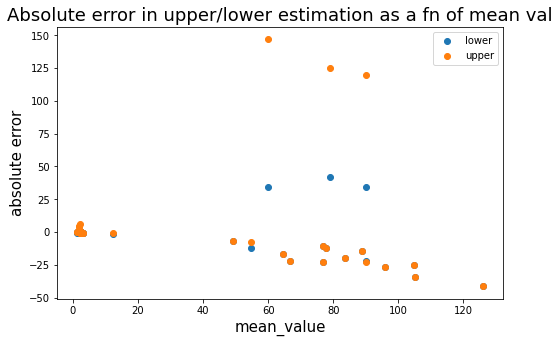

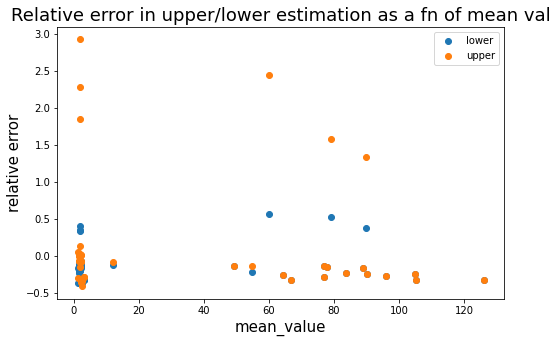

In [93]:
gday.loc[gday.value_025_percentile=='na','value_025_percentile'] = np.nan
gday.value_025_percentile = gday.value_025_percentile.astype(float)

gday.loc[gday.value_975_percentile=='na','value_975_percentile'] = np.nan
gday.value_975_percentile = gday.value_975_percentile.astype(float)

lower_error = gday.lower - gday.value_025_percentile 
upper_error = gday.value_975_percentile - gday.upper

errors = pd.DataFrame({'lower':lower_error,'upper':upper_error,'value_mean':gday.value_mean})

plt.figure(figsize=(8,5))
plt.scatter(x = errors.value_mean, y = errors.lower, label = 'lower')
plt.scatter(x = errors.value_mean, y = errors.upper, label = 'upper')

plt.xlabel('mean_value', fontsize=15)
plt.ylabel('absolute error', fontsize=15)
plt.title('Absolute error in upper/lower estimation as a fn of mean val', fontsize=18)

plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(x = errors.value_mean, y = errors.lower/errors.value_mean, label = 'lower')
plt.scatter(x = errors.value_mean, y = errors.upper/errors.value_mean, label = 'upper')

plt.xlabel('mean_value', fontsize=15)
plt.ylabel('relative error', fontsize=15)
plt.title('Relative error in upper/lower estimation as a fn of mean val', fontsize=18)

plt.legend()
plt.show()